# Early Childhood Education Impacts

## Introduction
Early childhood is a critical stage of development and a period that widens the divide between the advantaged and the systemically disadvantaged. Education is often proffered as an answer to problems of poverty and inequality, so I wanted investigate whether current systems are having the desired impact. I became especially interested in a new program by the World Bank called SABER (Systems Approach for Better Education Results). The program is relatively new with few data points, but I hope to use the World Bank data set containing education, population, labor, health, and economic data to determine if participation in SABER early childhood goals leads to improved outcomes for a country's children.

## Research Questions
- Does participation in the SABER early childhood goals lead to improved outcomes for children?
    - What can be considered a beneficial outcome tied to early childhood education?
    - What outcome might have been affected by pariticpation in the program for 5 or fewer years?
    - Which other indicators would make a meaningful model?
    - How much weight does SABER participation carry relative to other indicators?
    - Which indicators are missing from this data set that may prove more robust than those included? 

In [1]:
# Import the necessary libraries and classes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

from math import isnan
from collections import Counter
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score

%matplotlib inline

In [2]:
# Open and read the CSV file to a Dataframe
df = pd.read_csv('EdStatsData.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 886930 entries, 0 to 886929
Data columns (total 70 columns):
Country Name      886930 non-null object
Country Code      886930 non-null object
Indicator Name    886930 non-null object
Indicator Code    886930 non-null object
1970              72288 non-null float64
1971              35537 non-null float64
1972              35619 non-null float64
1973              35545 non-null float64
1974              35730 non-null float64
1975              87306 non-null float64
1976              37483 non-null float64
1977              37574 non-null float64
1978              37576 non-null float64
1979              36809 non-null float64
1980              89122 non-null float64
1981              38777 non-null float64
1982              37511 non-null float64
1983              38460 non-null float64
1984              38606 non-null float64
1985              90296 non-null float64
1986              39372 non-null float64
1987              38641 non-

In [4]:
# Save a dictionary matching the indicator code to its indicator name
# The indicator names are too long to be useful in a pandas data frame
ind_codes = df['Indicator Code'].unique().tolist()
ind_names = df['Indicator Name'].unique().tolist()
indicator_dict = {k:v for (k,v) in zip(ind_codes, ind_names)}

## Isolate Countries
The dataframe has indicators for countries but also for groups and classes of countries. I am only interested in the individual countries, so I need to remove all other groupings for countries. Then I will drop the country code and indicator name because they are less useful than country name and indicator code for selecting values in the data frame.

In [5]:
# Create a List of regions in the dataset
regions = ['Arab World', 'East Asia & Pacific', 'East Asia & Pacific (excluding high income)', 'Euro area', 'Europe & Central Asia', 
 'Europe & Central Asia (excluding high income)', 'European Union', 'Latin America & Caribbean', 'Latin America & Caribbean (excluding high income)', 
  'Middle East & North Africa', 'Middle East & North Africa (excluding high income)', 'Middle income', 'North America', 'South Asia', 
           'Sub-Saharan Africa', 'Sub-Saharan Africa (excluding high income)', 'OECD members', 'World']

# Create a List of income levels in the dataset
income_levels = ['Heavily indebted poor countries (HIPC)', 'High income', 'Least developed countries: UN classification', 'Low & middle income', 
 'Low income', 'Lower middle income', 'Upper middle income']

# Remove all records for regions and income level groups
df = df[~df['Country Name'].isin(regions)]
df = df[~df['Country Name'].isin(income_levels)]

# Drop unnecessary country code and indicator name columns
df.drop(['Country Code', 'Indicator Name'], axis=1, inplace=True)


df.head()

,Country Name,Indicator Code,1970,1971,1972,1973,1974,1975,1976,1977,...,2060,2065,2070,2075,2080,2085,2090,2095,2100,Unnamed: 69
91625,Afghanistan,UIS.NERA.2,NaN,NaN,NaN,NaN,7.05911,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91626,Afghanistan,UIS.NERA.2.F,NaN,NaN,NaN,NaN,2.53138,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91627,Afghanistan,UIS.NERA.2.GPI,NaN,NaN,NaN,NaN,0.22154,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91628,Afghanistan,UIS.NERA.2.M,NaN,NaN,NaN,NaN,11.42652,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91629,Afghanistan,SE.PRM.TENR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Isolate Years of Interest
The World Bank's SABER program does not contain data before 2010, so we can drop all other years.

In [6]:
# Reduce data frame to only the years of interest, country, and indicator code
df = df.loc[:, ['Country Name', 'Indicator Code', '2010', '2011', '2012',
            '2013', '2014', '2015']]
df.head()

,Country Name,Indicator Code,2010,2011,2012,2013,2014,2015
91625,Afghanistan,UIS.NERA.2,NaN,NaN,NaN,47.436790,50.627232,NaN
91626,Afghanistan,UIS.NERA.2.F,NaN,NaN,NaN,34.073261,37.641541,NaN
91627,Afghanistan,UIS.NERA.2.GPI,NaN,NaN,NaN,0.567060,0.598370,NaN
91628,Afghanistan,UIS.NERA.2.M,NaN,NaN,NaN,60.087059,62.906952,NaN
91629,Afghanistan,SE.PRM.TENR,NaN,NaN,NaN,NaN,NaN,NaN


## Feature Selection

### Outcome Variable

I found the densest features and looked through the metadata on them to determine which would make the best outcome variable. I ended up choosing *UIS.ROFST.1 - 'Rate of out-of-school children of primary school age, both sexes (%)'.* The rate of out-of-school primary students should be closely linked to educational outcomes in early childhood. Since each country will be starting from different rates, I will transform the variable to an average rate of change over the 6 years in this dataset.

### Model Features

In previous notebooks, I ran models with the densest features and the selected outcome variable to arrive at the features that best describe variance in the outcome variable. Using Lasso regression, the coefficients went to 0 for all but three of the features in my feature set: 

- Gross National Product
- Population
- Mortality < 5 years old

I chose to keep those features not only for their performance in the model, but because they are theoretically sound as well. Wealthier countries with lower infant mortality are likely to have a lower rate of out-of-school primary-aged children because the people of those countries are probably better able to meet their basic physical and security needs and focus on the future of their children. Absolute population size probably has an interactional effect dependent on the economic level of the country. I expect to see greater error within less populous countries than more populous countries in predicting variance.

Even taking an average year-over-year change and a current value for each of the features above would only give me 6 features to put up against the SABER participation feature. I decided to add a few more features based on which were theoretically interesting for exploring correlation to primary out-of-school rate and which had sufficient data for at least 150 countries.

- Official entrance age to primary education (years)
- Duration of compulsory education (years)
- Unemployment, total (% of total labor force)
- Percentage of students in lower secondary general education who are female (%)
- Gross outbound enrolment ratio, all regions, both sexes (%)

Since a higher value in the outcome variable represent a negative outcome (a higher rate of primary-aged children out of school), I would hypothesize the following correlations:

### Negative Hypothesized Correlation with Outcome

- Gross National Product
- Duration of compulsory education (years)
- Percentage of students in lower secondary general education who are female (%)
- Gross outbound enrolment ratio, all regions, both sexes (%)

### Positive Hypothesized Correlation with Outcome

- Mortality < 5 years old
- Official entrance age to primary education (years)
- Unemployment, total (% of total labor force)


In [7]:
# Find Country-Indicator rows that have at least two values for the years of interest
df.dropna(thresh=2, axis=0, subset=['2010', '2011', '2012', '2013', '2014', '2015'], inplace=True)

In [8]:
# Find possible indicators that have 2 or more values for at least 150 countries
pd.options.display.max_rows=None
pf_groups = df.groupby('Indicator Code')[['Country Name']].count()
possible_indicators = pf_groups.loc[pf_groups['Country Name'] > 150].index.tolist()
possible_indicators

['IT.NET.USER.P2',
 'NY.GDP.MKTP.CD',
 'NY.GDP.MKTP.KD',
 'NY.GDP.MKTP.PP.CD',
 'NY.GDP.MKTP.PP.KD',
 'NY.GDP.PCAP.CD',
 'NY.GDP.PCAP.KD',
 'NY.GDP.PCAP.PP.CD',
 'NY.GDP.PCAP.PP.KD',
 'NY.GNP.MKTP.CD',
 'NY.GNP.MKTP.PP.CD',
 'NY.GNP.PCAP.CD',
 'NY.GNP.PCAP.PP.CD',
 'PRJ.ATT.1519.1.FE',
 'PRJ.ATT.1519.1.MA',
 'PRJ.ATT.1519.1.MF',
 'PRJ.ATT.1519.2.FE',
 'PRJ.ATT.1519.2.MA',
 'PRJ.ATT.1519.2.MF',
 'PRJ.ATT.1519.3.FE',
 'PRJ.ATT.1519.3.MA',
 'PRJ.ATT.1519.3.MF',
 'PRJ.ATT.1519.4.FE',
 'PRJ.ATT.1519.4.MA',
 'PRJ.ATT.1519.4.MF',
 'PRJ.ATT.1519.NED.FE',
 'PRJ.ATT.1519.NED.MA',
 'PRJ.ATT.1519.NED.MF',
 'PRJ.ATT.1519.S1.FE',
 'PRJ.ATT.1519.S1.MA',
 'PRJ.ATT.1519.S1.MF',
 'PRJ.ATT.15UP.1.FE',
 'PRJ.ATT.15UP.1.MA',
 'PRJ.ATT.15UP.1.MF',
 'PRJ.ATT.15UP.2.FE',
 'PRJ.ATT.15UP.2.MA',
 'PRJ.ATT.15UP.2.MF',
 'PRJ.ATT.15UP.3.FE',
 'PRJ.ATT.15UP.3.MA',
 'PRJ.ATT.15UP.3.MF',
 'PRJ.ATT.15UP.4.FE',
 'PRJ.ATT.15UP.4.MA',
 'PRJ.ATT.15UP.4.MF',
 'PRJ.ATT.15UP.NED.FE',
 'PRJ.ATT.15UP.NED.MA',
 'PRJ.ATT.15UP.NED

In [9]:
# Reduce the features in the data frame to those in possible indicators that are not projections
df = df[df['Indicator Code'].isin(possible_indicators)]
df = df[~df['Indicator Code'].str.startswith('PRJ')]
len(df['Indicator Code'].unique().tolist())

413

In [10]:
# Make dictionaries encoding indicator codes and country names to numbers
indicator_code_dict = {ind_codes[i]:i for i in range(len(ind_codes))}
country_list = df['Country Name'].unique().tolist()
country_name_dict = {country_list[i]:i for i in range(len(country_list))}

# Replace strings with numbers to convert data frame to numpy array
possible_features = df.replace({'Country Name':country_name_dict, 'Indicator Code':indicator_code_dict}).copy()

In [11]:
# Create average change in primary out-of-school rate as an outcome variable
outcome_code = indicator_code_dict['UIS.ROFST.1']
outcome_df = possible_features.loc[possible_features['Indicator Code']==outcome_code]

outcome_arr = outcome_df.to_numpy('float64').tolist()

# Take the mean of the differences between adjacent columns
for i in range(len(outcome_arr)):
    outcome_arr[i] = np.append(outcome_arr[i], np.nanmean(np.diff(outcome_arr[i][2:])))

C:\Users\Jeff\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


In [12]:
# Convert back to array for better indexing
outcome_arr = np.array(outcome_arr)

In [13]:
# Make an outcome variable data frame with country column
y = outcome_arr[:, 0]

y= y.tolist()

for i in range(len(outcome_arr)):
    y[i] = np.append(y[i], outcome_arr[i, -1])

y = pd.DataFrame(y, columns=['Country', 'Outcome'])
y.fillna(0, inplace=True)

y.head()

,Country,Outcome
0,1.0,-1.221755
1,2.0,-0.089580
2,5.0,-2.672871
3,6.0,-0.304173
4,7.0,-0.152110


In [14]:
# For efficient calculation of average year-to-year change variables, convert to numpy array
# To allow for appending, make the first dimension of the array a list
pf_arr = possible_features.to_numpy('float64')
pf_arr = pf_arr.tolist()
len(pf_arr)

73217

In [15]:
# For each row, check find the most current year where the value is not NaN
for i in range(len(pf_arr)):
    for x in pf_arr[i][-1:2:-1]:
        if not isnan(x):
            pf_arr[i] = np.append(pf_arr[i], x)
            break

In [16]:
pf_arr = np.array(pf_arr)
X = pf_arr[:, :2]
len(X)

73217

In [17]:
X = X.tolist()
for i in range(len(X)):
    X[i] = np.append(X[i], pf_arr[i, -1])

X = pd.DataFrame(X, columns=['Country', 'Indicator', 'Current'])
X.head()

,Country,Indicator,Current
0,0.0,702.0,9.0
1,0.0,1133.0,652756.0
2,0.0,1134.0,238935.0
3,0.0,1135.0,1159427.0
4,0.0,1136.0,465590.0


In [18]:
# Create dicitionaries to undo encoding of indicator code and country name 
icd = {v:k for k, v in indicator_code_dict.items()}
cnd = {v:k for k, v in country_name_dict.items()}

# Convert codes to integers so the dictionaries can recognize them
X[['Country', 'Indicator']] = X[['Country', 'Indicator']].astype('int64')

# Decode country name and indicator
X.replace({'Country':cnd, 'Indicator':icd}, inplace=True)
y.replace({'Country':cnd}, inplace=True)

# Set country name and indcator code to indices, then unstack indicator so that each row represents a country
# and each column represents an indicator's average change or current value
X.set_index(['Country', 'Indicator'], inplace=True)
X = X.unstack('Indicator')
X.describe()

Current                                                  \
Indicator IT.NET.USER.P2 NY.GDP.MKTP.CD NY.GDP.MKTP.KD NY.GDP.MKTP.PP.CD   
count         203.000000   2.040000e+02   1.980000e+02      1.900000e+02   
mean           48.625392   3.634550e+11   3.785746e+11      6.004443e+11   
std            28.629396   1.565181e+12   1.474396e+12      2.119844e+12   
min             0.000000   3.267328e+07   3.675181e+07      3.901246e+07   
25%            21.708049   6.037413e+09   6.872180e+09      1.895341e+10   
50%            50.300000   2.653079e+10   2.615917e+10      6.786928e+10   
75%            72.999350   1.808273e+11   1.887519e+11      3.373404e+11   
max            98.323610   1.812071e+13   1.664039e+13      1.985273e+13   

                                                                             \
Indicator NY.GDP.MKTP.PP.KD NY.GDP.PCAP.CD NY.GDP.PCAP.KD NY.GDP.PCAP.PP.CD   
count          1.900000e+02     204.000000     198.000000        190.000000   
mean           5.640502e+11   15840.134423   14549.797750      19650.817113   
std            1.988371e+12   24337.876187   19758.417340      21650.941776   
min            3.656509e+07     300.676557     226.528058        668.337622   
25%            1.776440e+10    1907.072860    1781.400727       3880.158954   
50%            6.336194e+10    5794.173133    5971.511366      11988.997278   
75%            3.220336e+11   17420.244925   16977.214108      26814.873380   
max            1.860731e+13  168146.015281  107648.608008     127764.462337   

                                            ...                            \
Indicator NY.GDP.PCAP.PP.KD NY.GNP.MKTP.CD  ... UIS.SLE.123.M  UIS.SLE.23   
count            190.000000   1.940000e+02  ...    155.000000  160.000000   
mean           18367.972018   3.829521e+11  ...     11.491102    5.439134   
std            20177.774846   1.630106e+12  ...      1.825027    1.918710   
min              626.410873   5.566178e+07  ...      5.753510    1.255620   
25%             3636.745374   7.329975e+09  ...     10.516330    4.141298   
50%            11302.366372   3.117630e+10  ...     11.741660    5.596580   
75%            25233.593444   1.816128e+11  ...     12.562360    6.894995   
max           119749.428536   1.858114e+13  ...     15.612120    9.510410   

                                                                \
Indicator UIS.SLE.23.F UIS.SLE.23.GPI UIS.SLE.23.M UIS.THAGE.0   
count       159.000000     159.000000   159.000000  204.000000   
mean          5.426435       0.980187     5.457551    3.367647   
std           2.016664       0.127087     1.866347    0.609556   
min           0.848940       0.457360     1.349280    3.000000   
25%           4.214395       0.962395     4.322705    3.000000   
50%           5.728290       0.999560     5.471450    3.000000   
75%           6.906060       1.044870     6.940145    4.000000   
max          10.038920       1.369910     9.291240    5.000000   

                                                                             
Indicator UIS.THAGE.3.A.GPV UIS.THAGE.4.A.GPV UIS.THDUR.0 UIS.THDUR.4.A.GPV  
count            204.000000        160.000000  205.000000        159.000000  
mean              15.181373         17.956250    2.692683          1.861635  
std                0.843080          1.183465    0.712765          0.758730  
min               13.000000         14.000000    1.000000          1.000000  
25%               15.000000         17.750000    2.000000          1.000000  
50%               15.000000         18.000000    3.000000          2.000000  
75%               16.000000         19.000000    3.000000          2.000000  
max               18.000000         23.000000    4.000000          5.000000  

[8 rows x 413 columns]

In [19]:
# Flatten multi-index by dropping level current
X.columns = X.columns.droplevel()
X.head()

Indicator,IT.NET.USER.P2,NY.GDP.MKTP.CD,NY.GDP.MKTP.KD,NY.GDP.MKTP.PP.CD,NY.GDP.MKTP.PP.KD,NY.GDP.PCAP.CD,NY.GDP.PCAP.KD,NY.GDP.PCAP.PP.CD,NY.GDP.PCAP.PP.KD,NY.GNP.MKTP.CD,...,UIS.SLE.123.M,UIS.SLE.23,UIS.SLE.23.F,UIS.SLE.23.GPI,UIS.SLE.23.M,UIS.THAGE.0,UIS.THAGE.3.A.GPV,UIS.THAGE.4.A.GPV,UIS.THDUR.0,UIS.THDUR.4.A.GPV
Country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,8.260000,1.921556e+10,2.021272e+10,6.291767e+10,5.897066e+10,569.577923,599.135196,1864.973641,1747.978457,1.938857e+10,...,12.17043,3.38414,2.40201,0.55734,4.30974,3.0,16.0,19.0,2.0,2.0
Albania,63.252933,1.133526e+10,1.303516e+10,3.298144e+10,3.160484e+10,3934.895394,4524.990993,11449.094589,10971.223704,1.122583e+10,...,12.53132,6.69177,6.44182,0.93016,6.92548,3.0,15.0,18.0,3.0,2.0
Algeria,38.200000,1.658743e+11,1.897723e+11,5.838525e+11,5.472257e+11,4160.220067,4759.595242,14643.343064,13724.723853,1.604671e+11,...,12.86950,6.99021,7.11805,1.03655,6.86707,5.0,15.0,NaN,1.0,NaN
American Samoa,NaN,6.590000e+08,5.489339e+08,NaN,NaN,11865.963232,9884.111866,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Andorra,96.910000,2.811489e+09,3.258327e+09,NaN,NaN,36038.267604,41765.920353,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3.0,16.0,18.0,3.0,1.0


In [20]:
X.fillna(0, inplace=True)

In [21]:
X = X[X.index.isin(y['Country'].tolist())]

In [22]:
y = y['Outcome']
y.head()

0   -1.221755
1   -0.089580
2   -2.672871
3   -0.304173
4   -0.152110
Name: Outcome, dtype: float64

In [23]:
reg = LinearRegression()

reg.fit(X, y)
coefficients = reg.coef_
print(reg.score(X, y))

cvscore = cross_val_score(reg, X, y, cv=4)
print(cvscore)
print(np.mean(cvscore))

0.9999981515135109
[  -8939.81894598 -148742.42371776  -41993.88776604   -1706.56000231]
-50345.67260802229


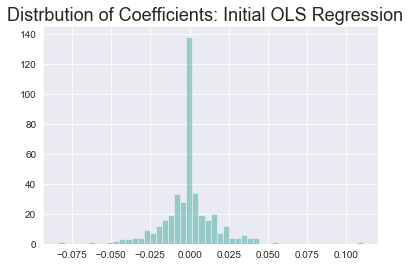

In [24]:
sns.set_style('darkgrid')
sns.distplot(coefficients,  color='#1A9988', kde=False)
plt.figtext(.5, .9,'Distrbution of Coefficients: Initial OLS Regression', fontsize=18, ha='center')
plt.show()

In [25]:
las = Lasso(alpha=0.5)

las.fit(X, y)
lasso_coef = las.coef_
print(las.score(X,y))

0.5523623123375516


C:\Users\Jeff\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


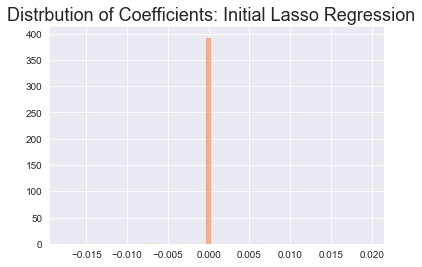

In [26]:
sns.distplot(lasso_coef,  color='#EB5600', kde=False)
plt.figtext(.5, .9,'Distrbution of Coefficients: Initial Lasso Regression', fontsize=18, ha='center')
plt.show()

In [27]:
selector = SelectKBest(f_regression, k=75)
selector.fit(X, y)
cols = selector.get_support(indices=True)
X = X.iloc[:, cols]
X.head()

Indicator,IT.NET.USER.P2,NY.GNP.PCAP.CD,SE.COM.DURS,SE.ENR.PRSC.FM.ZS,SE.ENR.SECO.FM.ZS,SE.PRE.ENRL.FE.ZS,SE.PRE.ENRR,SE.PRE.ENRR.FE,SE.PRE.ENRR.MA,SE.PRM.ENRL.TC.ZS,...,UIS.SLE.12.M,UIS.SLE.123,UIS.SLE.123.F,UIS.SLE.123.GPI,UIS.SLE.123.M,UIS.SLE.23,UIS.SLE.23.F,UIS.SLE.23.GPI,UIS.SLE.23.M,UIS.THAGE.3.A.GPV
Country,,,,,,,,,,,,,,,,,,,,,
Albania,63.252933,4290.0,9.0,0.94666,0.93600,47.553761,88.602242,87.398911,89.722321,18.61557,...,9.55280,12.24150,11.93081,0.95208,12.53132,6.69177,6.44182,0.93016,6.92548,15.0
Algeria,38.200000,4800.0,10.0,0.99096,1.03655,49.368309,79.212807,79.477119,78.956779,23.83613,...,11.49082,12.79765,12.72297,0.98861,12.86950,6.99021,7.11805,1.03655,6.86707,15.0
Angola,12.400000,4040.0,6.0,0.63950,0.64825,59.338558,79.248230,94.400131,64.208473,42.54306,...,11.19017,9.85388,7.67512,0.63803,12.02931,1.73392,1.36449,0.64825,2.10488,15.0
Antigua and Barbuda,70.000000,12850.0,11.0,0.97597,1.02115,49.276932,95.643150,94.521500,96.758621,14.33428,...,10.60408,11.90727,11.65952,0.95922,12.15522,5.12253,5.12757,1.00134,5.12069,15.0
Argentina,68.043064,12430.0,14.0,1.02966,1.06717,49.488800,72.753937,73.278099,72.247612,0.00000,...,10.55109,13.05926,13.25748,1.03033,12.86721,6.39484,6.62978,1.07500,6.16724,15.0


In [28]:
reg.fit(X, y)

coefficients = reg.coef_
print(reg.score(X, y))

cvscore = cross_val_score(reg, X, y, cv=4)
print(cvscore)
print(np.mean(cvscore))

0.6322643184036429
[-2.02223726e+02 -1.33108139e+01 -8.45021547e+04 -7.40151597e+00]
-21181.27269078008


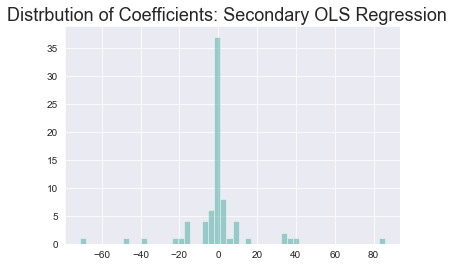

In [29]:
sns.distplot(coefficients,  color='#1A9988', kde=False)
plt.figtext(.5, .9,'Distrbution of Coefficients: Secondary OLS Regression', fontsize=18, ha='center')
plt.show()

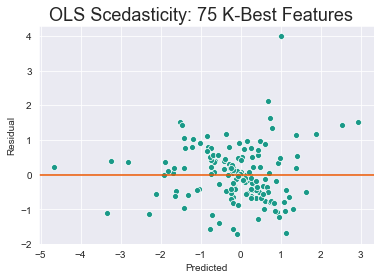

In [30]:
# Determine the scedasticity of the model
predictions = reg.predict(X)

residuals = y - predictions

sns.scatterplot(predictions, residuals,  color='#1A9988')
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0, color='#EB5600')
plt.figtext(.5, .9, 'OLS Scedasticity: 75 K-Best Features', fontsize=18, ha='center')
plt.show()

In [31]:
las = Lasso(alpha=0.5)

las.fit(X, y)
lasso_coef = las.coef_
print(las.score(X,y))

0.3248100991459806


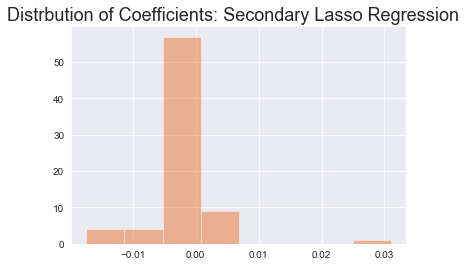

In [32]:
sns.distplot(lasso_coef,  color='#EB5600', kde=False)
plt.figtext(.5, .9,'Distrbution of Coefficients: Secondary Lasso Regression', fontsize=18, ha='center')
plt.show()

In [33]:
potential_features = X.columns[np.where(lasso_coef != 0)]
potential_features

Index(['IT.NET.USER.P2', 'NY.GNP.PCAP.CD', 'SE.PRE.ENRL.FE.ZS', 'SE.PRE.ENRR',
       'SE.PRM.ENRL.TC.ZS', 'SE.PRM.ENRR.MA', 'SE.PRM.GINT.MA.ZS',
       'SE.PRM.GINT.ZS', 'SE.PRM.TCHR.FE.ZS', 'SE.SEC.ENRL.FE.ZS',
       'SE.SEC.ENRR.LO.FE', 'SE.SEC.ENRR.MA', 'SE.SEC.ENRR.UP.FE',
       'SE.TER.ENRR', 'SH.DYN.MORT', 'SL.TLF.TOTL.FE.ZS', 'UIS.FEP.3',
       'UIS.GER.12', 'UIS.GER.12.F', 'UIS.GER.12.M', 'UIS.GTVP.2.GPV',
       'UIS.GTVP.23.GPV.M', 'UIS.PRP.2', 'UIS.R.1'],
      dtype='object', name='Indicator')

In [34]:
# Create a list of indicator codes for the features of interest
final_features = ['SP.POP.TOTL', 'SE.PRM.AGES', 'SE.COM.DURS', 'SH.DYN.MORT', 'SL.UEM.TOTL.ZS', 
                  'SL.TLF.TOTL.FE.ZS', 'UIS.FEP.2.GPV', 'UIS.GOER.56', 'NY.GNP.PCAP.PP.CD', 'UIS.ROFST.1']

features_df = df[df['Indicator Code'].isin(final_features)].copy()

In [35]:
final_names = {e: indicator_dict[e] for e in final_features}
final_names

{'SP.POP.TOTL': 'Population, total',
 'SE.PRM.AGES': 'Official entrance age to primary education (years)',
 'SE.COM.DURS': 'Duration of compulsory education (years)',
 'SH.DYN.MORT': 'Mortality rate, under-5 (per 1,000)',
 'SL.UEM.TOTL.ZS': 'Unemployment, total (% of total labor force)',
 'SL.TLF.TOTL.FE.ZS': 'Labor force, female (% of total labor force)',
 'UIS.FEP.2.GPV': 'Percentage of students in lower secondary general education who are female (%)',
 'UIS.GOER.56': 'Gross outbound enrolment ratio, all regions, both sexes (%)',
 'NY.GNP.PCAP.PP.CD': 'GNI per capita, PPP (current international $)',
 'UIS.ROFST.1': 'Rate of out-of-school children of primary school age, both sexes (%)'}

In [36]:
# Make a copy of the data frame that has only the features for the model, backfill then frontfill any NaNs
features_df = features_df.fillna(method='bfill', axis=1)
features_df.iloc[:, 2:] = features_df.iloc[:, 2:].fillna(method='ffill', axis=1)

In [37]:
# Check which countries have no values in the outcome variable
pd.options.display.max_rows=None
features_df.loc[features_df['Indicator Code']=='UIS.ROFST.1']

,Country Name,Indicator Code,2010,2011,2012,2013,2014,2015
97851,Albania,UIS.ROFST.1,8.96613,6.77434,3.86291,4.0874,4.07911,4.07911
101516,Algeria,UIS.ROFST.1,1.33952,1.24994,1.18697,1.18697,1.18697,1.18697
112511,Angola,UIS.ROFST.1,18.6606,15.9877,15.9877,15.9877,15.9877,15.9877
116176,Antigua and Barbuda,UIS.ROFST.1,10.521,12.4559,14.0288,14.1671,14.1671,9.7467
119841,Argentina,UIS.ROFST.1,0.93389,0.8593,0.81555,0.64579,0.32545,0.32545
127171,Aruba,UIS.ROFST.1,1.07954,0.69276,0.69276,0.69276,0.69276,0.69276
130836,Australia,UIS.ROFST.1,2.89435,2.23424,2.34474,2.54961,2.86182,2.83959
138166,Azerbaijan,UIS.ROFST.1,15.2739,12.7319,10.71,6.32932,5.1879,5.73725
145496,Bahrain,UIS.ROFST.1,8.10034,8.10034,7.26567,6.2672,4.2789,2.0009
152826,Barbados,UIS.ROFST.1,4.91948,6.38363,8.51318,8.51318,8.51318,8.51318


## Countries and Indicators to Drop

### Countries
I sought to retain as many countries as possible for comparison in this model. I needed to drop any countries that had no values for the outcome variable. I also dropped those countries that were not sovereign nations and any countries missing all values for two or more of the features.

### Indicators
When engineering features, I thought it would be beneficial to have both a current measure and a measure of change for all indicators. This turns out to be unnecessary for some of the features with good reason. *Official entrance age to primary education (years)* and *Duration of compulsory education (years)* are unlikely to change much on a year to year basis over the course of six years for most countries. The current value should suffice for these two indicators and I will drop the average change columns. About one quarter of all countries are have no change or are missing change in values for *Average years of total schooling, age 25+*, but I will keep it in the feature set anyway because it could theoretically have an impact on the outcome variable (increasingly educated parents could be more diligent about keeping their children in primary school). I will also retain the change in unemployment column because I believe decreasing unemployment could lead to decreasing primary out-of-school rates.


In [38]:
# Create a list of countries that have no values in the outcome variable to be dropped
drop_countries = ['Afghanistan', 'American Samoa', 'Andorra', 'Aruba', 'Austria', 'Bermuda', 
                  'Bosnia and Herzegovina', 'British Virgin Islands', 'Brunei Darussalam', 
                  'Cayman Islands', 'Channel Islands', 'China', 'Congo, Dem. Rep.', 'Curacao', 
                  'Czech Republic', 'Dominica', 'Faroe Islands', 'French Polynesia', 'Gabon', 
                  'Gibraltar', 'Greenland', 'Guam', 'Haiti', 'Hong Kong SAR, China', 'Iraq', 
                  'Isle of Man', 'Jamaica', 'Kosovo', 'Libya', 'Liechtenstein', 'Madagascar', 'Macao SAR, China',
                  'Malawi', 'Maldives', 'Micronesia, Fed. Sts.', 'Monaco', 'Nauru', 'New Caledonia', 
                  'Northern Mariana Islands', 'Puerto Rico', 'Singapore', 'Sint Maarten (Dutch part)', 
                  'Slovak Republic', 'Somalia', 'South Africa', 'St. Martin (French part)', 
                  'St. Lucia', 'Turkmenistan', 'Turks and Caicos Islands', 'Virgin Islands (U.S.)']

# Make a list of indices in the data frame where these countries are found
drop_indices = features_df.loc[features_df['Country Name'].isin(drop_countries)].index.tolist()

# Drop all instances of these countries
features_df.drop(drop_indices, axis=0, inplace=True)

In [39]:
# Check the desnity of values by indicator code
features_df.groupby('Indicator Code').apply(lambda x: x.notnull().sum())

,Country Name,Indicator Code,2010,2011,2012,2013,2014,2015
Indicator Code,,,,,,,,
NY.GNP.PCAP.PP.CD,161,161,161,161,161,161,161,161
SE.COM.DURS,156,156,156,156,156,156,156,156
SE.PRM.AGES,167,167,167,167,167,167,167,167
SH.DYN.MORT,167,167,167,167,167,167,167,167
SL.TLF.TOTL.FE.ZS,157,157,157,157,157,157,157,157
SL.UEM.TOTL.ZS,157,157,157,157,157,157,157,157
SP.POP.TOTL,167,167,167,167,167,167,167,167
UIS.FEP.2.GPV,156,156,156,156,156,156,156,156
UIS.GOER.56,148,148,148,148,148,148,148,148


In [40]:
# Replace strings with numbers to convert data frame to numpy array
features_df.replace({'Country Name':country_name_dict, 'Indicator Code':indicator_code_dict}, inplace=True)

In [41]:
# For efficient calculation of average year-to-year change variables, convert to numpy array
# To allow for appending, make the first dimension of the array a list
features_arr = features_df.to_numpy('float64')
features_arr = features_arr.tolist()

In [42]:
# For each row, take the mean of the year to year differences, ignoring NaNs
for i in range(len(features_arr)):
    features_arr[i] = np.append(features_arr[i], np.nanmean(np.diff(features_arr[i][2:])))

In [43]:
# For each row, check find the most current year where the value is not NaN
for i in range(len(features_arr)):
    for x in features_arr[i][-2:2:-1]:
        if not isnan(x):
            features_arr[i] = np.append(features_arr[i], x)
            break

In [44]:
# Convert the first dimension back to an array for accurate slicing
features_arr = np.array(features_arr)

In [45]:
# Set X equal to the country and indicator columns
features = features_arr[:, :2]

# Convert back to list for appending the current and average change columns
features = features.tolist()
for i in range(len(features)):
    features[i] = np.append(features[i], features_arr[i, -2:])
    
# Convert numpy array to data frame
features = pd.DataFrame(features, columns=['Country', 'Indicator', 'AverageChange', 'Current'])

# Create dicitionaries to undo encoding of indicator code and country name 
icd = {v:k for k, v in indicator_code_dict.items()}
cnd = {v:k for k, v in country_name_dict.items()}

# Convert codes to integers so the dictionaries can recognize them
features[['Country', 'Indicator']] = features[['Country', 'Indicator']].astype('int64')

# Decode country name and indicator
features.replace({'Country':cnd, 'Indicator':icd}, inplace=True)

# Set country name and indcator code to indices, then unstack indicator so that each row represents a country
# and each column represents an indicator's average change or current value
features.set_index(['Country', 'Indicator'], inplace=True)
features = features.unstack('Indicator')

# Flatten multi-index by combining column names levels 0 and 1 into a single name
col_names = pd.Index([e[1] + e[0] for e in features.columns.tolist()])
features.columns = col_names

# Remove the current out-of-school rate since it is a component of the outcome variable
# Drop two of the columns from the indicators that are predominantly 0
features.drop(['SE.COM.DURSAverageChange', 'SE.PRM.AGESAverageChange', 'UIS.ROFST.1Current'], axis=1, inplace=True)

In [46]:
# Read in SABER participation values and remove fractional or negative values
saber_df = pd.read_csv('saber_dict.csv')
saber_df.rename(columns={'Unnamed: 0': 'Country', 'SABER.ERL.CHLD.GOAL1':  'SABERParticipation'}, inplace=True)
saber_df = saber_df[['Country', 'SABERParticipation']]
saber_df['SABERParticipation'] = saber_df['SABERParticipation'].apply(lambda x: 0 if x < 1 else x)

# Remove countries not in X, set index to Country
saber_df = saber_df[saber_df['Country'].isin(X.index)]
saber_df.set_index('Country', inplace=True)

# Merge feature set with SABER participation variable, put outcome variable at the end
features = features.merge(saber_df, left_index=True, right_index=True)
features = features[[c for c in features if c not in ['UIS.ROFST.1AverageChange']] + ['UIS.ROFST.1AverageChange']] 

# Fill any remaining null values with 0
features.fillna(0, inplace=True)
features.describe()

,NY.GNP.PCAP.PP.CDAverageChange,SH.DYN.MORTAverageChange,SL.TLF.TOTL.FE.ZSAverageChange,SL.UEM.TOTL.ZSAverageChange,SP.POP.TOTLAverageChange,UIS.FEP.2.GPVAverageChange,UIS.GOER.56AverageChange,NY.GNP.PCAP.PP.CDCurrent,SE.COM.DURSCurrent,SE.PRM.AGESCurrent,SH.DYN.MORTCurrent,SL.TLF.TOTL.FE.ZSCurrent,SL.UEM.TOTL.ZSCurrent,SP.POP.TOTLCurrent,UIS.FEP.2.GPVCurrent,UIS.GOER.56Current,SABERParticipation,UIS.ROFST.1AverageChange
count,153.000000,153.000000,153.000000,153.000000,1.530000e+02,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,1.530000e+02,153.000000,153.000000,153.000000,153.000000
mean,559.725490,-1.291895,0.072875,-0.062614,4.037322e+05,0.077524,0.061068,18188.431373,9.156863,6.091503,30.659477,38.374232,8.006536,3.310928e+07,47.397969,2.954961,0.346405,-0.065434
std,661.235449,1.607523,0.220832,0.481695,1.362200e+06,0.249699,0.510638,19520.498710,3.179121,0.554402,31.256604,13.637741,6.478108,1.133585e+08,7.372546,8.019195,0.868455,0.851705
min,-472.000000,-8.180000,-0.906761,-2.100000,-1.858000e+05,-0.621194,-0.360710,0.000000,0.000000,5.000000,2.200000,0.000000,0.000000,1.100100e+04,0.000000,0.000000,0.000000,-3.217100
25%,112.000000,-2.060000,-0.038882,-0.220000,4.391600e+03,-0.059200,-0.012498,3810.000000,8.000000,6.000000,7.700000,37.091853,4.000000,2.174645e+06,47.817539,0.378190,0.000000,-0.404554
50%,348.000000,-0.560000,0.064971,-0.020000,1.018000e+05,0.016864,0.000000,11340.000000,9.000000,6.000000,16.600000,42.899938,6.300000,9.154302e+06,48.650021,1.121560,0.000000,-0.043572
75%,836.000000,-0.160000,0.165839,0.060000,3.686672e+05,0.184911,0.031444,25200.000000,11.000000,6.000000,48.000000,47.023512,10.000000,2.785930e+07,49.547741,2.803020,0.000000,0.248322
max,3598.000000,0.320000,0.819100,2.440000,1.561466e+07,1.089587,6.099379,125000.000000,15.000000,7.000000,130.900000,54.975901,31.299999,1.309054e+09,60.173210,85.998627,5.000000,4.260080


In [47]:
# Instantiate scaler and scale features using Z-score
scaler = StandardScaler(copy=True)

features_scaled = scaler.fit_transform(features)
features_scaled = pd.DataFrame(features_scaled, columns=features.columns)

# Divide feature set into current and average change features
col_list = features_scaled.columns.tolist()
list1 = col_list[:7]
list2 = col_list[7:]
list1.append(col_list[-2])
list1.append(col_list[-1])


features_change = features_scaled[list1].copy()
features_current = features_scaled[list2].copy()
features_change.head()

,NY.GNP.PCAP.PP.CDAverageChange,SH.DYN.MORTAverageChange,SL.TLF.TOTL.FE.ZSAverageChange,SL.UEM.TOTL.ZSAverageChange,SP.POP.TOTLAverageChange,UIS.FEP.2.GPVAverageChange,UIS.GOER.56AverageChange,SABERParticipation,UIS.ROFST.1AverageChange
0,-0.306076,0.481754,-0.652048,1.338451,-0.302116,-1.123302,-0.242519,-0.400185,-1.074275
1,-0.366767,0.581613,0.927024,0.630291,0.255605,-1.167362,-0.129419,-0.400185,0.041139
2,-0.527599,-3.300402,-0.233069,0.130415,0.364062,-1.674148,-0.128106,-0.400185,-0.552634
3,-0.029929,0.606578,-0.331088,0.130415,-0.296581,0.192439,-0.828695,-0.400185,-0.105342
4,-0.157381,0.444307,0.303846,-0.077868,0.025810,-0.797750,-0.150957,-0.400185,-0.066266


## Assumptions for Modeling

- Linear Relationship
    - Check with pairplot
- Low Multicollinearity
    - Check with Correlation
- Homoscedasticity
    - Run model and graph error distributions

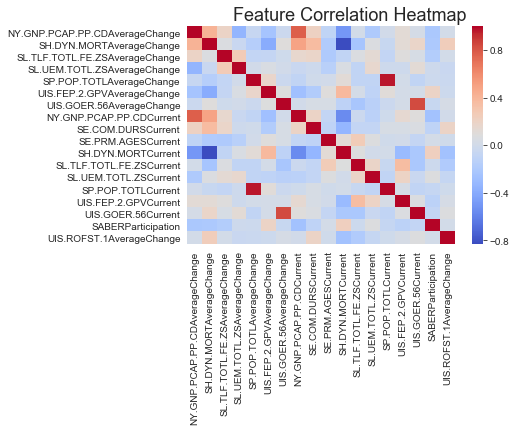

In [48]:
# Create a heatmap of the correlations between variables in the feature set
sns.heatmap(features.corr(), cmap='coolwarm')
plt.figtext(.5, .9,'Feature Correlation Heatmap', fontsize=18, ha='center')
plt.show()

<Figure size 1080x720 with 0 Axes>

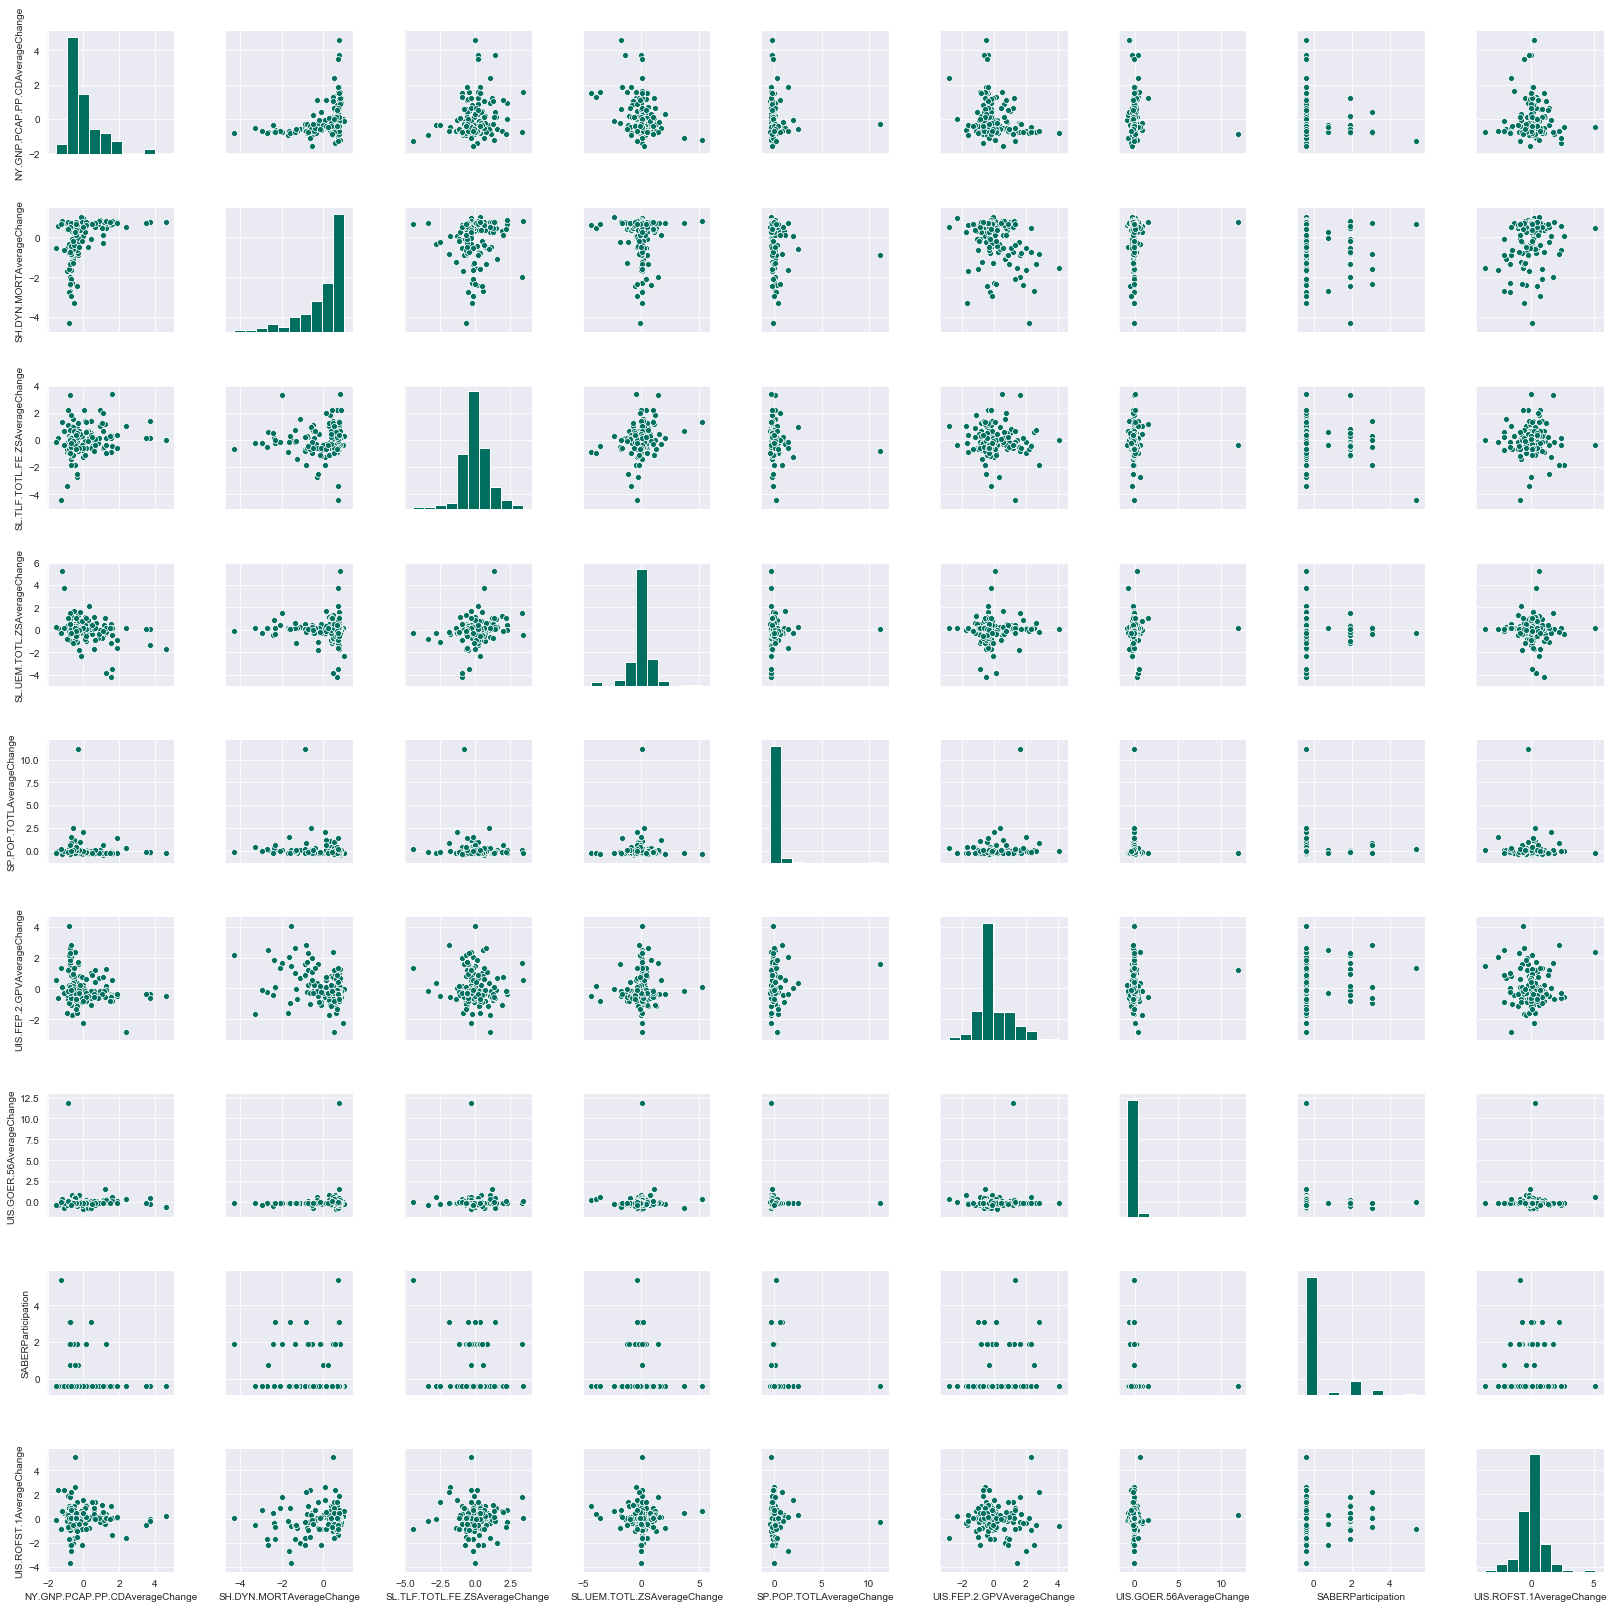

In [49]:
sns.set_palette("PuBuGn_r")

plt.figure(figsize=(15,10))
sns.pairplot(features_change)
plt.show()

<Figure size 1080x720 with 0 Axes>

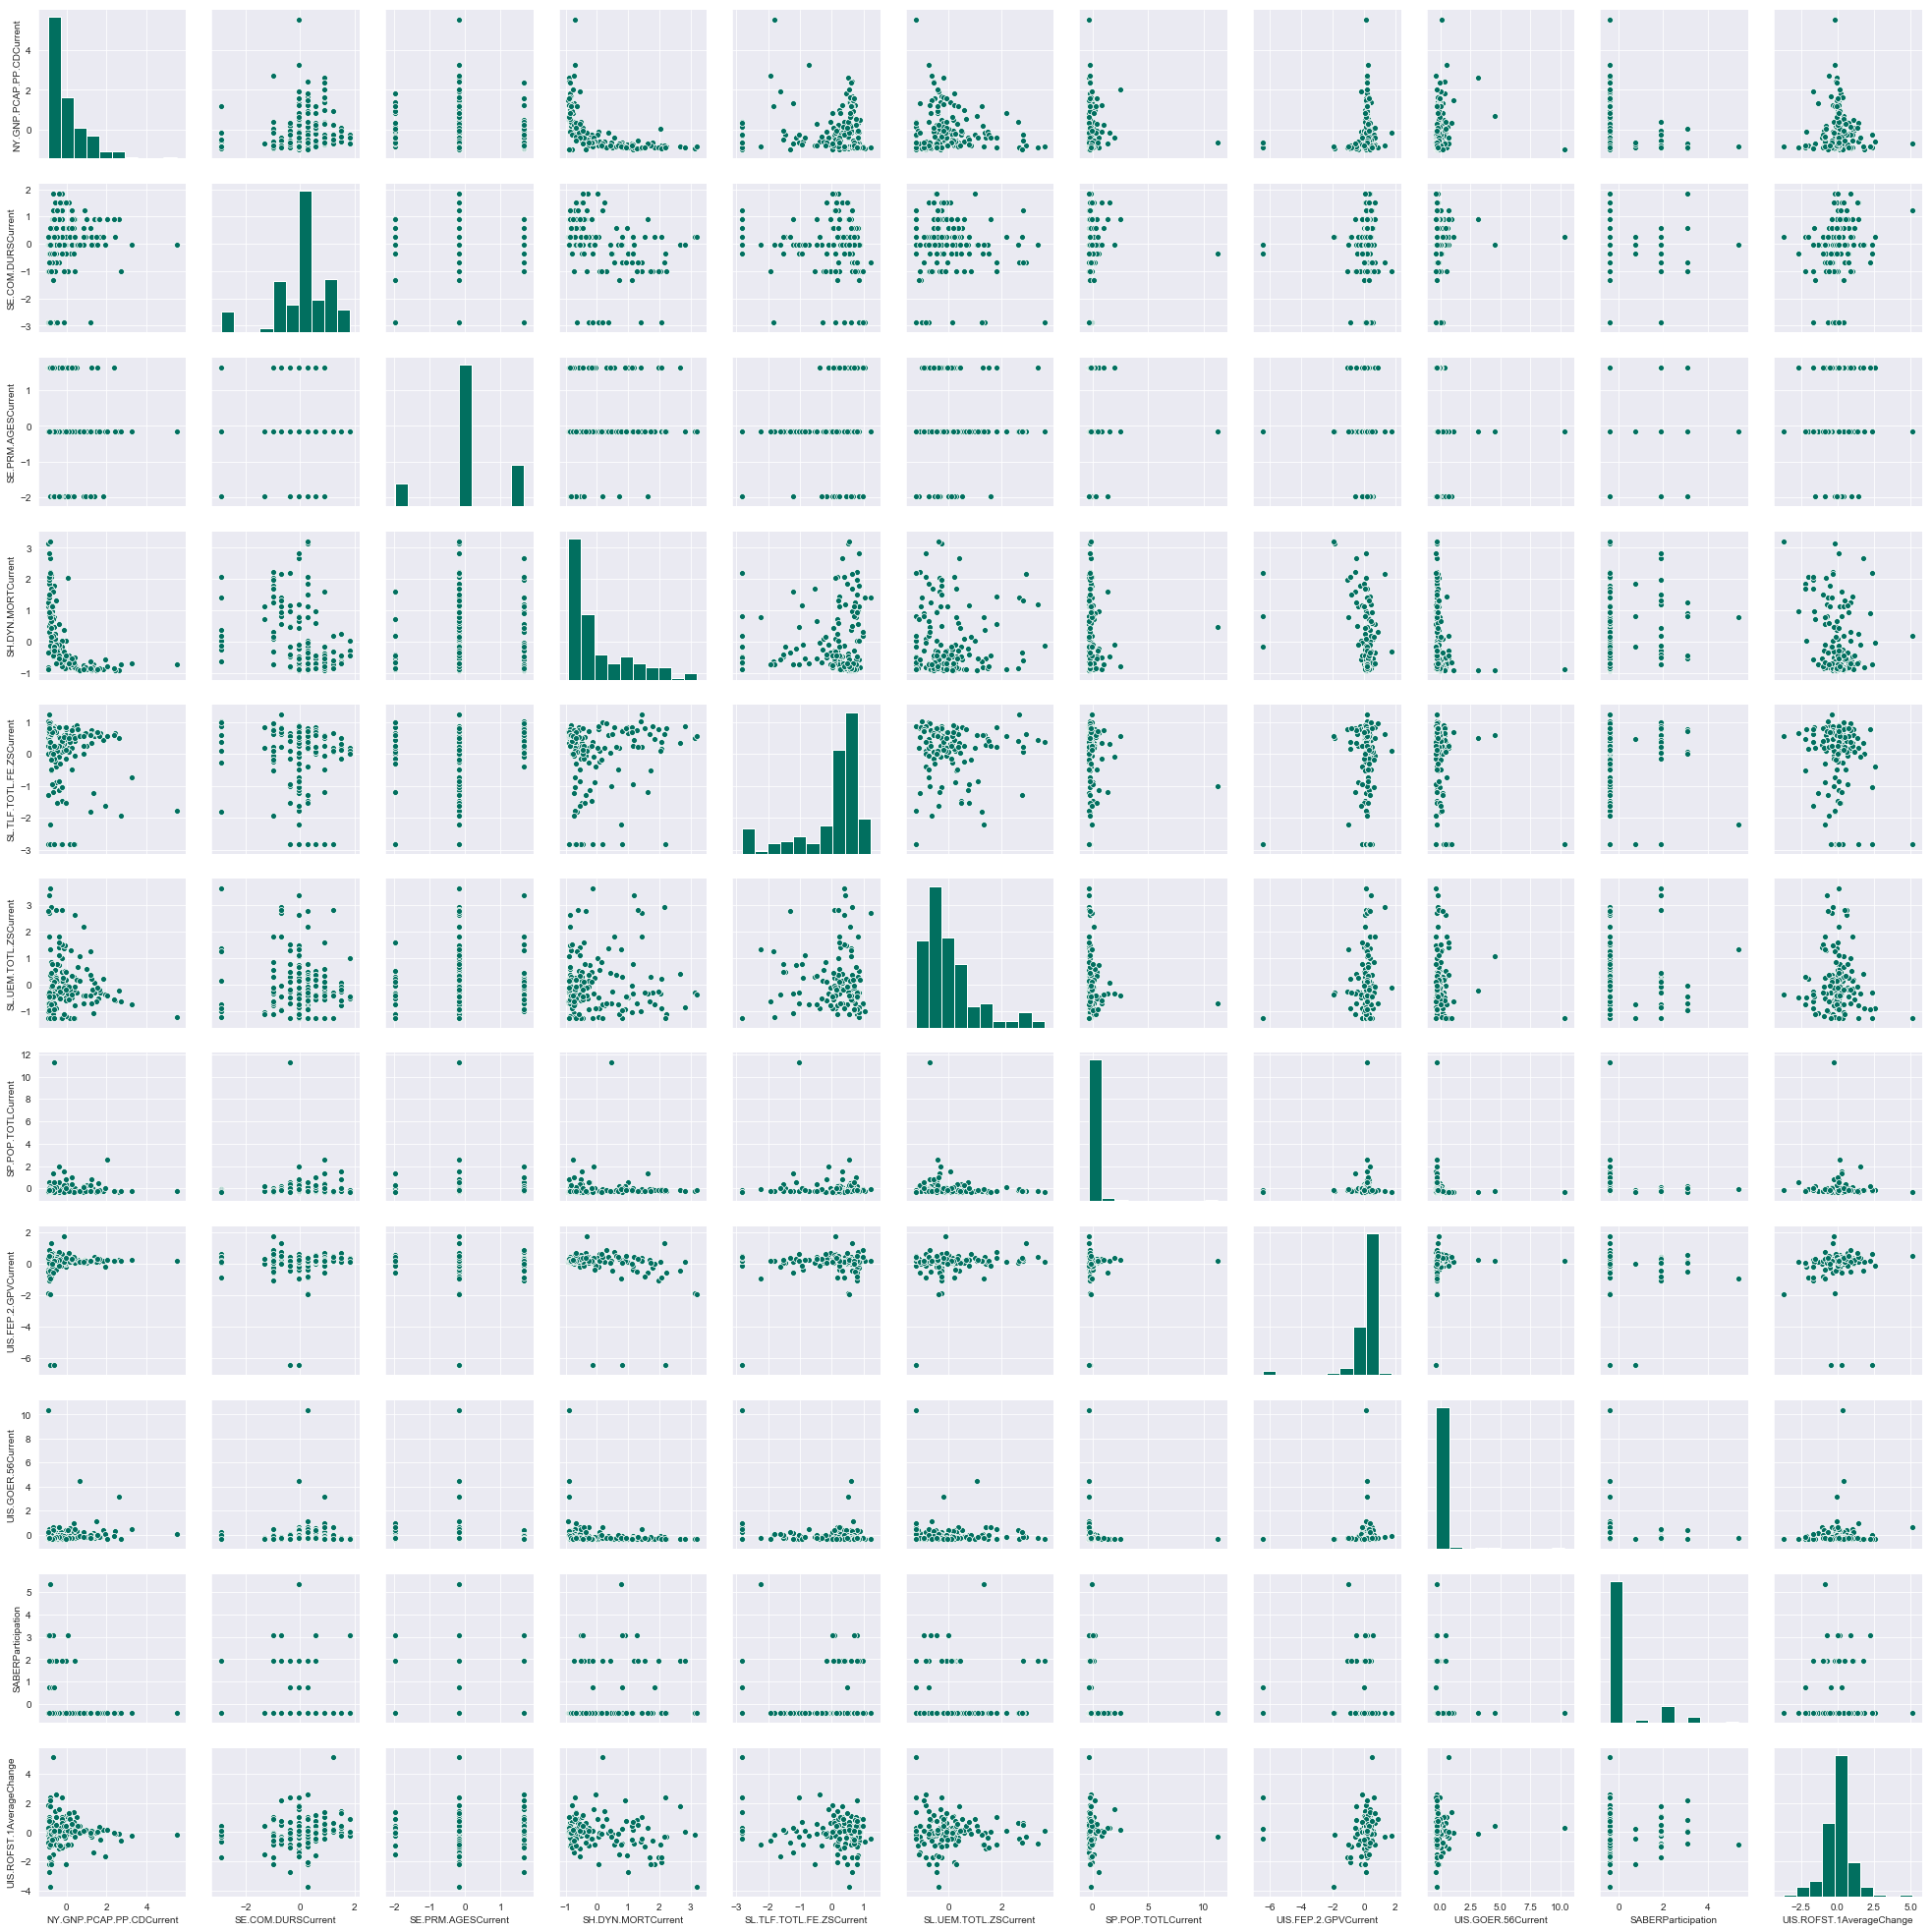

In [50]:
plt.figure(figsize=(15,10))
sns.pairplot(features_current)
plt.show()

In [51]:
# Separate outcome variable from feature set
y = features_scaled.iloc[:, -1].copy()

# Drop the outcome variable from the feature set
features_scaled = features_scaled.drop('UIS.ROFST.1AverageChange', axis=1)
features_change = features_change.drop('UIS.ROFST.1AverageChange', axis=1)
features_current = features_current.drop('UIS.ROFST.1AverageChange', axis=1)

In [52]:
def make_linear_model(X, y, featureset):
    # Create a statsmodel formula-friendly copy of the data, then create the formula
    data = X.copy()
    data['Outcome'] = y
    data.columns = data.columns.str.replace('.', '_')
    formula = str('Outcome ~ ' + '+'.join(data.columns[:-1]))
    
    lm = smf.ols(formula=formula, data=data).fit()

    # Create coefficients variable
    coefficients = lm.params[1:]
    
    # Create confidence interval variable
    yerr = lm.conf_int().values[1:]
    yerr = np.diff(yerr)
    
    # Get model score
    score = lm.rsquared
    
    # Get p-values for determining significance of features
    pvalues = lm.pvalues[1:]
    
    # Make a list to populate results data frame
    results = ['OLS', featureset, 'None', score]
    results.extend(pvalues)
    
    # Get predictions
    predictions = lm.predict(data)
    
    return coefficients, yerr, pvalues, predictions, results    
    

In [53]:
def make_ensemble_model(X, y, model, featureset, param_dict, cv):
    # Instantiate model
    if model == 'rfr':
        mdl = RandomForestRegressor()
        mdl_name = 'Random Forest Regressor'
    elif model == 'gbr':
        mdl = GradientBoostingRegressor()
        mdl_name = 'Gradient Boosting Regression'
    else:
        print('Model argument must be "rfr" or "gbr".')
        
    # Fit best model through GridsearchCV
    gscv = GridSearchCV(mdl, param_dict, cv=cv, iid=True, return_train_score=True)
    gscv.fit(X, y)
    
    # Get results and find best scoring model
    res = pd.DataFrame(gscv.cv_results_)
    best_index = np.where(res['rank_test_score']==1)
    res = res.iloc[best_index]
    params = res['params'].tolist()[0]
    
    # Get model score
    score = res['mean_test_score'].tolist()[0]
    
    # Get feature importances
    if model == 'rfr':
        mdl_final = RandomForestRegressor(n_estimators=params['n_estimators'], 
                                          criterion=params['criterion'], 
                                          min_impurity_decrease=params['min_impurity_decrease'])
    else:
        mdl_final = GradientBoostingRegressor(n_estimators=params['n_estimators'], 
                                              learning_rate=params['learning_rate'])
       
    importances = mdl_final.fit(X, y).feature_importances_

    # Make a list to populate results data frame
    results = [mdl_name, featureset, params, score]
    results.extend(importances)
    
    return importances, results    

In [54]:
# OLS features scaled
scld_lincoef, scld_yerr, scld_pvalues, scld_pred, scld_res = make_linear_model(features_scaled, y, 'All - Scaled')

In [55]:
# OLS features change
chng_lincoef, chng_yerr, chng_pvalues, chng_pred, chng_res = make_linear_model(features_change, y, 'Change')

In [56]:
# OLS features current
cur_lincoef, cur_yerr, cur_pvalues, cur_pred, cur_res = make_linear_model(features_current, y, 'Current')

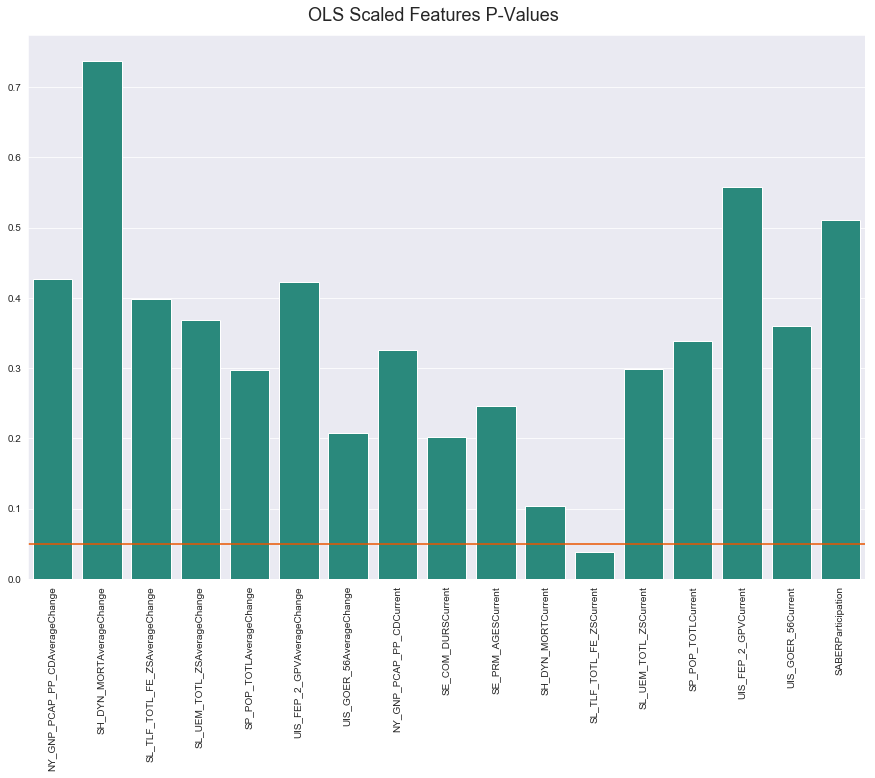

In [57]:
# Plot OLS features scaled p-values
plt.figure(figsize=(15,10))
sns.barplot(x=scld_pvalues.index, y=scld_pvalues.values, color='#1A9988')
plt.xticks(rotation=90)

# Plot horizontal line for conventional significance threshold
plt.axhline(0.05,  color='#EB5600')
plt.figtext(.5, .9,'OLS Scaled Features P-Values', fontsize=18, ha='center')
plt.show()

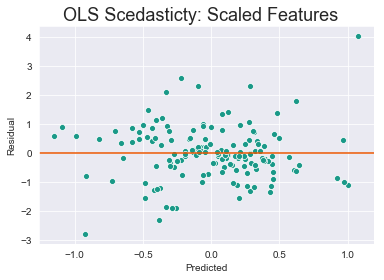

In [58]:
# Plot OLS features scaled scedasticity
# Calculate residuals
residuals = y - scld_pred

# Plot Residuals relative to predictions to visualize scedasticity
sns.scatterplot(scld_pred, residuals,  color='#1A9988')
plt.xlabel('Predicted')
plt.ylabel('Residual')

# Plot 0-line as a reference
plt.axhline(y=0, color='#EB5600')
plt.figtext(.5, .9,'OLS Scedasticty: Scaled Features', fontsize=18, ha='center')
plt.show()

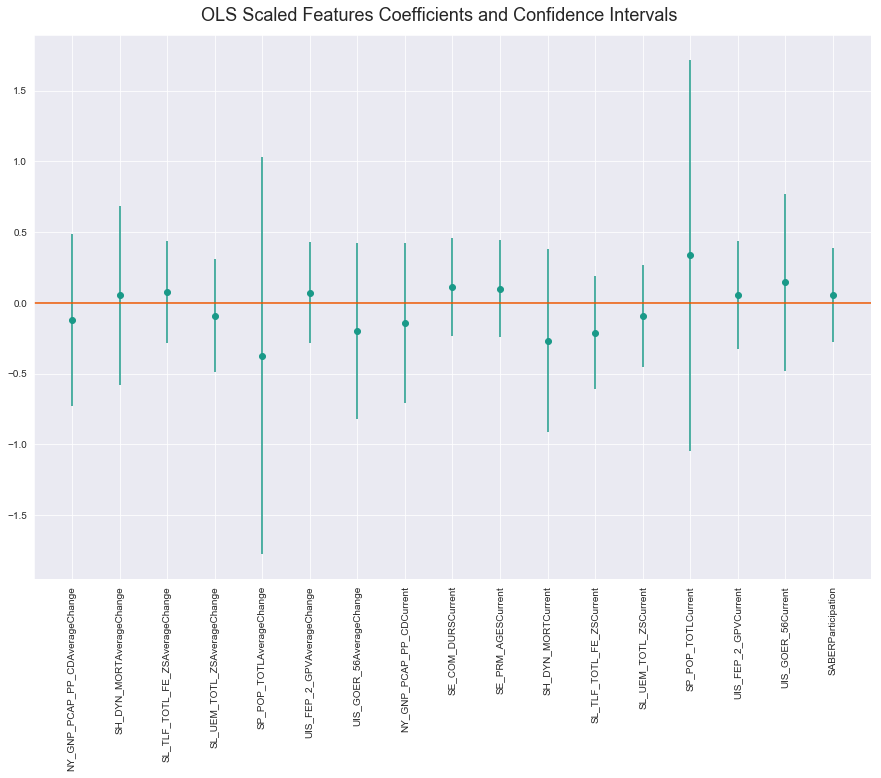

In [59]:
# Plot OLS features scaled coefficients and confidence intervals
fig, ax = plt.subplots(figsize=(15, 10))
ax.errorbar(x=scld_lincoef.index, y=scld_lincoef, yerr=scld_yerr, fmt='o', color='#1A9988')
plt.xticks(rotation=90)
plt.figtext(.5, .9,'OLS Scaled Features Coefficients and Confidence Intervals', fontsize=18, ha='center')
ax.axhline(y=0, color='#EB5600')
plt.show()

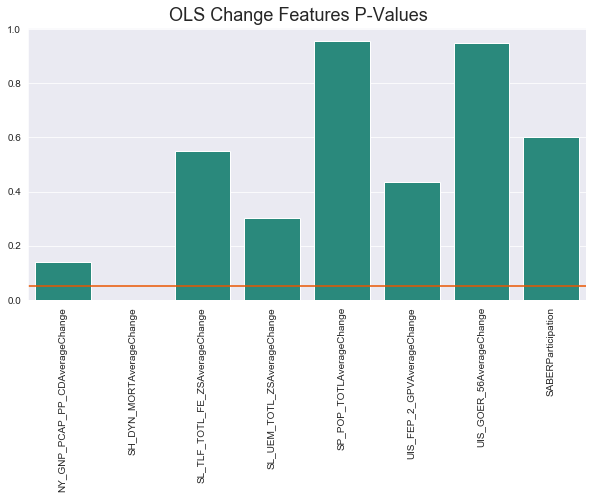

In [60]:
# Plot OLS features change p-values
plt.figure(figsize=(10,5))
sns.barplot(x=chng_pvalues.index, y=chng_pvalues.values, color='#1A9988')
plt.xticks(rotation=90)

# Plot horizontal line for conventional significance threshold
plt.axhline(0.05,  color='#EB5600')
plt.figtext(.5, .9,'OLS Change Features P-Values', fontsize=18, ha='center')
plt.show()

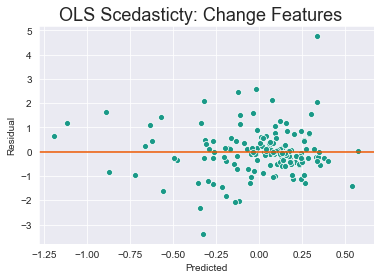

In [61]:
# Plot OLS features change scedasticity
# Calculate residuals
residuals = y - chng_pred

# Plot Residuals relative to predictions to visualize scedasticity
sns.scatterplot(chng_pred, residuals,  color='#1A9988')
plt.xlabel('Predicted')
plt.ylabel('Residual')

# Plot 0-line as a reference
plt.axhline(y=0, color='#EB5600')
plt.figtext(.5, .9,'OLS Scedasticty: Change Features', fontsize=18, ha='center')
plt.show()

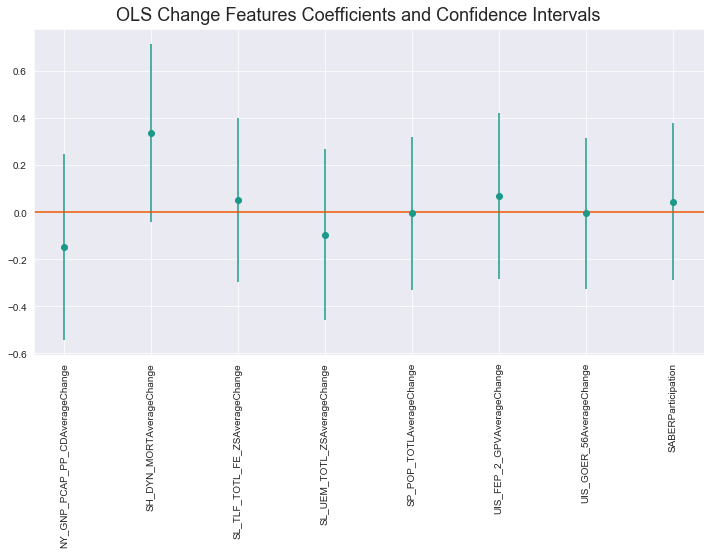

In [62]:
# Plot OLS features change coefficients and confidence intervals
fig, ax = plt.subplots(figsize=(12, 6))
ax.errorbar(x=chng_lincoef.index, y=chng_lincoef, yerr=chng_yerr, fmt='o', color='#1A9988')
plt.xticks(rotation=90)
plt.figtext(.5, .9,'OLS Change Features Coefficients and Confidence Intervals', fontsize=18, ha='center')
ax.axhline(y=0, color='#EB5600')
plt.show()

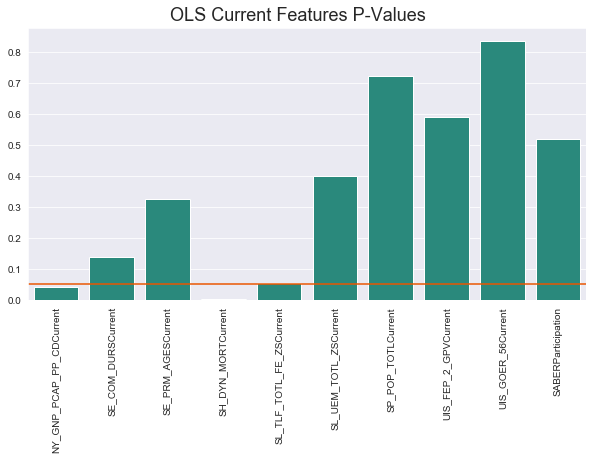

In [63]:
# Plot OLS features current p-values
plt.figure(figsize=(10,5))
sns.barplot(x=cur_pvalues.index, y=cur_pvalues.values, color='#1A9988')
plt.xticks(rotation=90)

# Plot horizontal line for conventional significance threshold
plt.axhline(0.05,  color='#EB5600')
plt.figtext(.5, .9,'OLS Current Features P-Values', fontsize=18, ha='center')
plt.show()

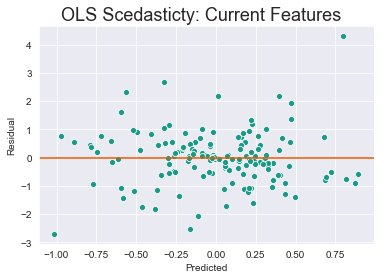

In [64]:
# Plot OLS features current scedasticity
# Calculate residuals
residuals = y - cur_pred

# Plot Residuals relative to predictions to visualize scedasticity
sns.scatterplot(cur_pred, residuals,  color='#1A9988')
plt.xlabel('Predicted')
plt.ylabel('Residual')

# Plot 0-line as a reference
plt.axhline(y=0, color='#EB5600')
plt.figtext(.5, .9,'OLS Scedasticty: Current Features', fontsize=18, ha='center')
plt.show()

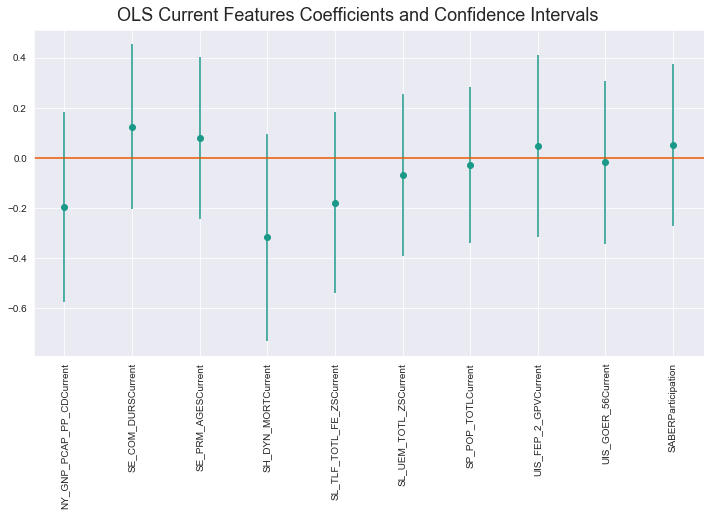

In [65]:
# Plot OLS features current coefficients and confidence intervals
fig, ax = plt.subplots(figsize=(12, 6))
ax.errorbar(x=cur_lincoef.index, y=cur_lincoef, yerr=cur_yerr, fmt='o', color='#1A9988')
plt.xticks(rotation=90)
plt.figtext(.5, .9,'OLS Current Features Coefficients and Confidence Intervals', fontsize=18, ha='center')
ax.axhline(y=0, color='#EB5600')
plt.show()

In [66]:
# RFR Scaled
# Create a dictionary of parameters to run a grid search cv on the Random Forest Model
rfr_params = {'n_estimators': [100, 200, 500], 'criterion': ['mse', 'mae'], 'min_impurity_decrease': [0.01, 0.001, 0.0001]}
scld_rfr_imp, scld_rfr_res = make_ensemble_model(features_scaled, y, 'rfr', 'All - Scaled', rfr_params, cv=4)

In [67]:
# RFR Change
chng_rfr_imp, chng_rfr_res = make_ensemble_model(features_change, y, 'rfr', 'Change', rfr_params, cv=4)

In [68]:
# RFR Current
cur_rfr_imp, cur_rfr_res = make_ensemble_model(features_current, y, 'rfr', 'Current', rfr_params, cv=4)

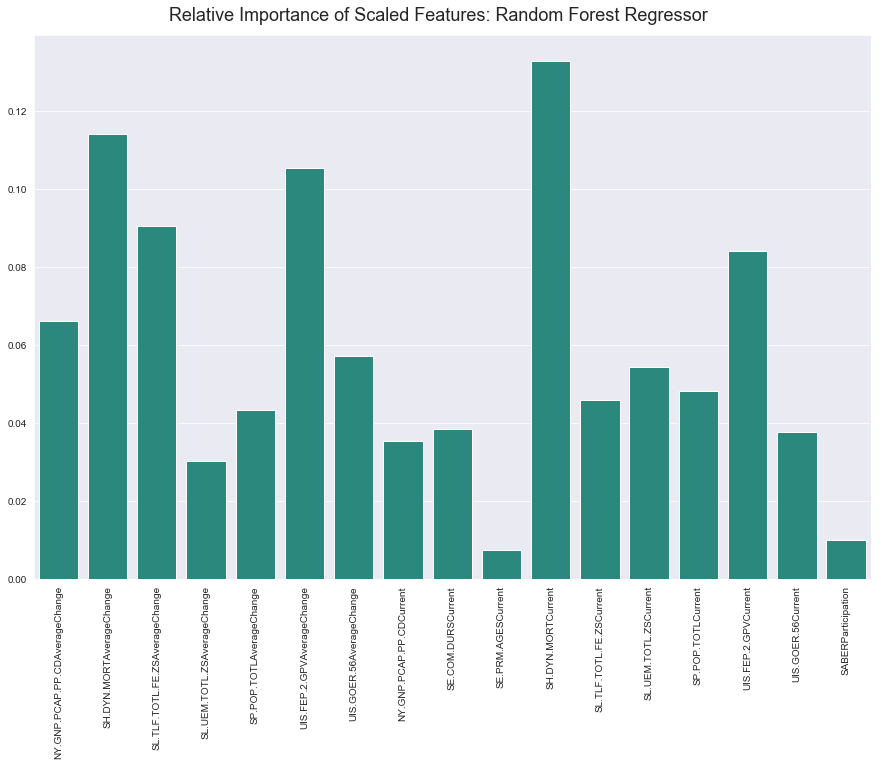

In [69]:
# RFR Scaled feature importances plot
plt.figure(figsize=(15,10))
sns.barplot(x=features_scaled.columns, y=scld_rfr_imp, color='#1A9988')
plt.figtext(.5, .9,'Relative Importance of Scaled Features: Random Forest Regressor', fontsize=18, ha='center')
plt.xticks(rotation=90)
plt.show()

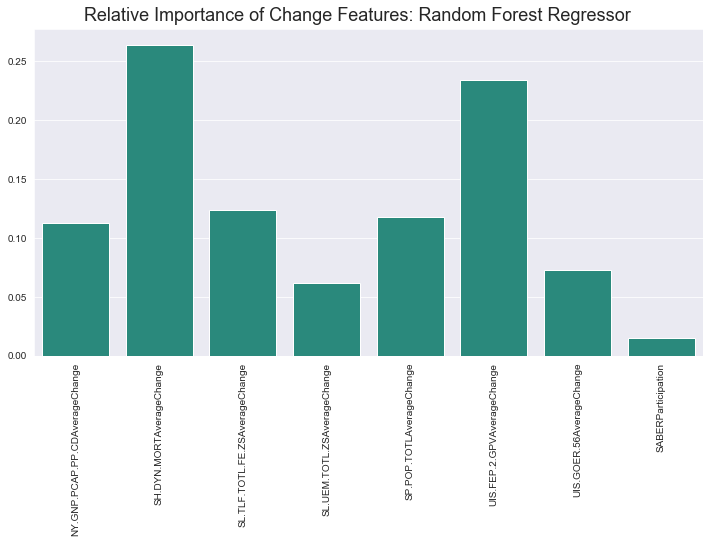

In [70]:
# RFR Change feature importances plot
plt.figure(figsize=(12,6))
sns.barplot(x=features_change.columns, y=chng_rfr_imp, color='#1A9988')
plt.figtext(.5, .9,'Relative Importance of Change Features: Random Forest Regressor', fontsize=18, ha='center')
plt.xticks(rotation=90)
plt.show()

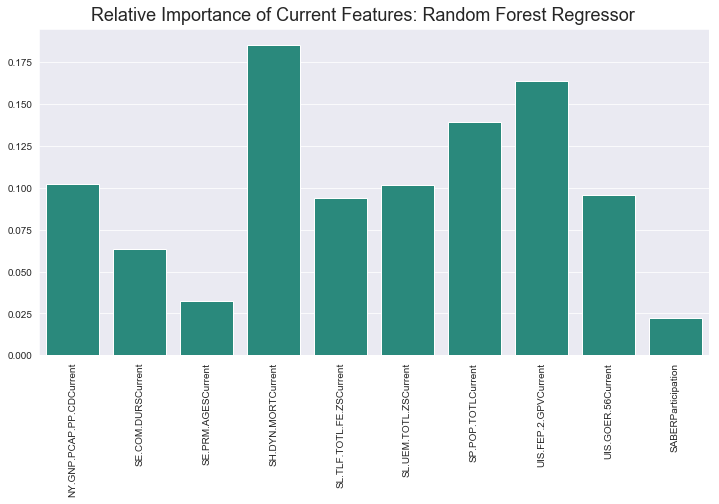

In [71]:
# RFR Current feature importances plot
plt.figure(figsize=(12,6))
sns.barplot(x=features_current.columns, y=cur_rfr_imp, color='#1A9988')
plt.figtext(.5, .9,'Relative Importance of Current Features: Random Forest Regressor', fontsize=18, ha='center')
plt.xticks(rotation=90)
plt.show()

In [72]:
# GBR Scaled
gbr_params = {'n_estimators': [100, 200, 500], 'learning_rate': [0.01, 0.001, 0.0001]}
scld_gbr_imp, scld_gbr_res = make_ensemble_model(features_scaled, y, 'gbr', 'All - Scaled', gbr_params, cv=4)

In [73]:
# GBR Change
chng_gbr_imp, chng_gbr_res = make_ensemble_model(features_change, y, 'gbr', 'Change', gbr_params, cv=4)

In [74]:
# GBR Current
cur_gbr_imp, cur_gbr_res = make_ensemble_model(features_current, y, 'gbr', 'Current', gbr_params, cv=4)

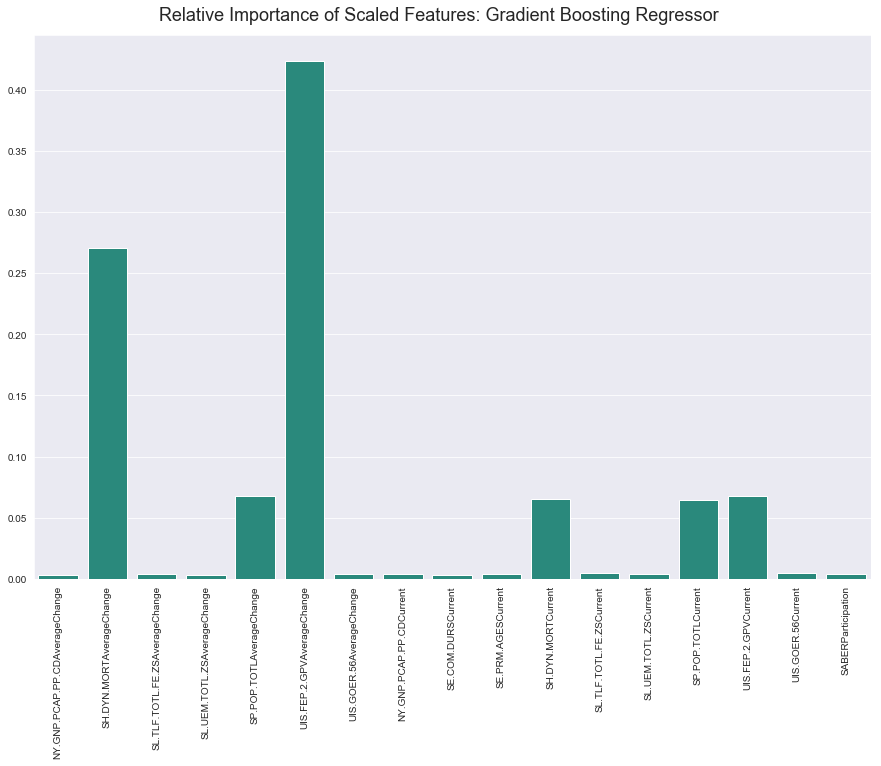

In [75]:
# GBR Scaled feature importances plot
plt.figure(figsize=(15,10))
sns.barplot(x=features_scaled.columns, y=scld_gbr_imp, color='#1A9988')
plt.figtext(.5, .9,'Relative Importance of Scaled Features: Gradient Boosting Regressor', fontsize=18, ha='center')
plt.xticks(rotation=90)
plt.show()

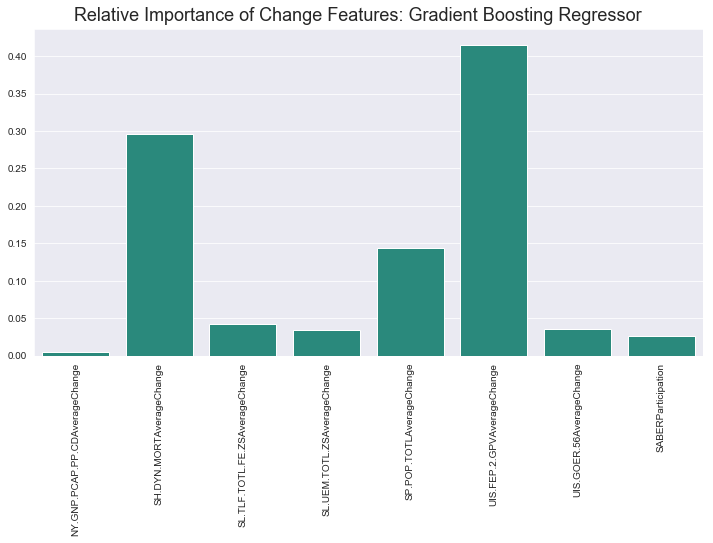

In [76]:
# GBR Change feature importances plot
plt.figure(figsize=(12,6))
sns.barplot(x=features_change.columns, y=chng_gbr_imp, color='#1A9988')
plt.figtext(.5, .9,'Relative Importance of Change Features: Gradient Boosting Regressor', fontsize=18, ha='center')
plt.xticks(rotation=90)
plt.show()

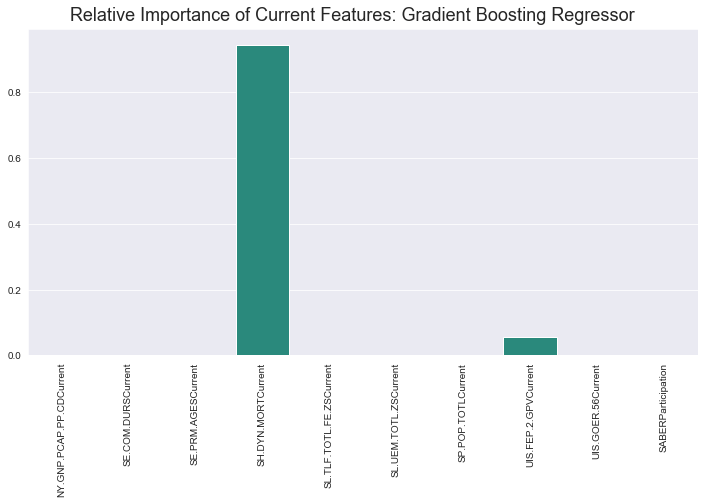

In [77]:
# GBR Current feature importances plot
plt.figure(figsize=(12,6))
sns.barplot(x=features_current.columns, y=cur_gbr_imp, color='#1A9988')
plt.figtext(.5, .9,'Relative Importance of Current Features: Gradient Boosting Regressor', fontsize=18, ha='center')
plt.xticks(rotation=90)
plt.show()

In [78]:
res_list = [scld_res, chng_res, cur_res, scld_rfr_res, chng_rfr_res, 
            cur_rfr_res, scld_gbr_res, chng_gbr_res, cur_gbr_res]
col_list = ['Model', 'Features', 'Parameters', 'Model Score']
feature_codes = features_scaled.columns.tolist()
col_list.extend(feature_codes)
res_df = pd.DataFrame(res_list, columns=col_list)

In [79]:
res_df.to_csv('result.csv')

## Conclusion

### Assumptions and Shortcomings of the Data and Models

- The dataset is a sparse dataset
- The problem is a complex problem
    - All factors that could contribute to the outcome have not been measured
    - All factors that could contribute to the outcome cannot been measured
- The features do not meet linear regression model assumptions
    - Features and outcome do not have linear relationship
    - Errors are not homoscedastic

### Conclusions and Next Steps

- Little statistical significance for SABER participation 2010-2015
- Correlation with:
    - Labor force, female (% of total labor force)
    - Mortality rate, under-5 (per 1,000)
    - Percentage of students in lower secondary general education who are female (%)
- Get change in score data with next measurement year 
